In [57]:
# basic
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

#Visualizing
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'; plt.rcParams['axes.unicode_minus'] = False;
import seaborn as sns

# sys
import warnings
warnings.filterwarnings('ignore')  # 시각화 할때 로그 무시


In [ ]:
%cd

C:\Users\j


## 데이터 전처리

### 데이터 정보확인

In [2]:
train = pd.read_csv('train.csv', encoding='euc-kr', parse_dates=['date_time']) # 'date_time'컬럼의 타입을 date타입으로 바꾸면서 csv로드
test = pd.read_csv('test.csv', encoding='euc-kr', parse_dates=['date_time'])
submission = pd.read_csv('sample_submission.csv', encoding='euc-kr')

In [3]:
train.head(1)

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0


In [4]:
test.head(1)

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25,27.8,1.5,74.0,0.0,0.0,NaN,NaN


In [5]:
print('\033[1m<test함수 변수별 결측값 수> \033[0m\n', train.isna().sum())

<test함수 변수별 결측값 수> 
 num           0
date_time     0
전력사용량(kWh)    0
기온(°C)        0
풍속(m/s)       0
습도(%)         0
강수량(mm)       0
일조(hr)        0
비전기냉방설비운영     0
태양광보유         0
dtype: int64


In [6]:
print('\033[1m<test함수 변수별 결측값 수> \033[0m\n', test.isna().sum())

<test함수 변수별 결측값 수> 
 num                0
date_time          0
기온(°C)          6720
풍속(m/s)         6720
습도(%)           6720
강수량(mm, 6시간)    8400
일조(hr, 3시간)     6720
비전기냉방설비운영       7784
태양광보유           8456
dtype: int64


### 날짜 인코딩


In [7]:
#요일
def weekday(x):
    if x.dayofweek == 6:
        return '일'
    elif x.dayofweek == 0:
        return '월'
    elif x.dayofweek == 1:
        return '화'
    elif x.dayofweek == 2:
        return '수'
    elif x.dayofweek == 3:
        return '목'
    elif x.dayofweek == 4:
        return '금'
    else:
        return '토'

# 주말 여부
def weekend(x):
    if x.dayofweek in [5, 6]:
        return 1
    else: 
        return 0

날짜 분해

In [8]:
train['month'] = train['date_time'].dt.month
train['day'] = train['date_time'].dt.day
train['hour'] = train['date_time'].dt.hour
train['weekday'] = train['date_time'].apply(weekday)
train['weekend'] = train['date_time'].apply(weekend)

test['month'] = test['date_time'].dt.month
test['day'] = test['date_time'].dt.day
test['hour'] = test['date_time'].dt.hour
test['weekday'] = test['date_time'].apply(weekday)
test['weekend'] = test['date_time'].apply(weekend)

In [9]:
train.head(10)

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,month,day,hour,weekday,weekend
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,6,1,0,월,0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,6,1,1,월,0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,6,1,2,월,0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,6,1,3,월,0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,6,1,4,월,0
5,1,2020-06-01 05:00:00,8010.576,16.9,3.4,93.0,0.0,0.0,0.0,0.0,6,1,5,월,0
6,1,2020-06-01 06:00:00,7978.176,16.7,3.4,90.0,0.1,0.0,0.0,0.0,6,1,6,월,0
7,1,2020-06-01 07:00:00,8019.000,16.9,2.3,86.0,0.0,0.1,0.0,0.0,6,1,7,월,0
8,1,2020-06-01 08:00:00,8020.944,17.8,3.3,80.0,0.0,0.3,0.0,0.0,6,1,8,월,0
9,1,2020-06-01 09:00:00,8083.152,19.3,2.1,73.0,0.0,0.7,0.0,0.0,6,1,9,월,0


In [10]:
train.describe()

,num,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,month,day,hour,weekend
count,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000
mean,30.500000,2324.830866,24.251713,2.151641,80.169848,0.514989,0.213533,0.683333,0.483333,6.929412,14.835294,11.500000,0.282353
std,17.318173,2058.999326,3.407902,1.514475,15.525862,2.624505,0.370517,0.465178,0.499724,0.793925,8.446192,6.922215,0.450146
min,1.000000,0.000000,11.100000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000,0.000000,0.000000
25%,15.750000,1055.268000,21.800000,1.100000,70.000000,0.000000,0.000000,0.000000,0.000000,6.000000,8.000000,5.750000,0.000000
50%,30.500000,1700.352000,24.200000,1.900000,84.000000,0.000000,0.000000,1.000000,0.000000,7.000000,15.000000,11.500000,0.000000
75%,45.250000,2780.487000,26.500000,2.900000,93.000000,0.000000,0.300000,1.000000,1.000000,8.000000,22.000000,17.250000,1.000000
max,60.000000,17739.225000,36.300000,20.100000,100.000000,81.500000,1.000000,1.000000,1.000000,8.000000,31.000000,23.000000,1.000000


### test data 결측치 처리

#### test 데이터 중 결측치 있는 변수:

- 비전기냉방설비운영, 태양광보유: 불규칙적으로 결측값 있음.
- 기온(°C),풍속(m/s), 습도(%), 일조(hr, 3시간): 3시간 단위로만 값이 있음 (0,3,6,9,12,15,18,21)
- 강수량(mm, 6시간): 6시간 단위로만 값이 있음 (0,6,12,18)

In [11]:
test.head(10)

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유,month,day,hour,weekday,weekend
0,1,2020-08-25 00:00:00,27.8,1.5,74.0,0.0,0.0,NaN,NaN,8,25,0,화,0
1,1,2020-08-25 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,25,1,화,0
2,1,2020-08-25 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,25,2,화,0
3,1,2020-08-25 03:00:00,27.3,1.1,78.0,NaN,0.0,NaN,NaN,8,25,3,화,0
4,1,2020-08-25 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,25,4,화,0
5,1,2020-08-25 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,25,5,화,0
6,1,2020-08-25 06:00:00,26.1,1.3,83.0,0.0,0.0,NaN,NaN,8,25,6,화,0
7,1,2020-08-25 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,25,7,화,0
8,1,2020-08-25 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,25,8,화,0
9,1,2020-08-25 09:00:00,28.8,1.2,77.0,NaN,1.1,NaN,NaN,8,25,9,화,0


In [12]:
test.describe()

,num,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유,month,day,hour,weekend
count,10080.000000,3360.000000,3360.000000,3360.000000,1680.000000,3360.000000,2296.0,1624.0,10080.0,10080.000000,10080.00000,10080.000000
mean,30.500000,27.805804,2.440327,81.963095,2.191845,0.612917,1.0,1.0,8.0,28.000000,11.50000,0.285714
std,17.318961,2.378122,1.835905,11.900843,6.786772,0.929587,0.0,0.0,0.0,2.000099,6.92253,0.451776
min,1.000000,22.100000,0.000000,44.000000,0.000000,0.000000,1.0,1.0,8.0,25.000000,0.00000,0.000000
25%,15.750000,26.000000,1.100000,74.000000,0.000000,0.000000,1.0,1.0,8.0,26.000000,5.75000,0.000000
50%,30.500000,27.500000,2.100000,83.000000,0.000000,0.000000,1.0,1.0,8.0,28.000000,11.50000,0.000000
75%,45.250000,29.200000,3.200000,92.000000,0.900000,1.000000,1.0,1.0,8.0,30.000000,17.25000,1.000000
max,60.000000,35.400000,22.500000,100.000000,83.500000,3.000000,1.0,1.0,8.0,31.000000,23.00000,1.000000


##### 1. '비전기냉방설비운영','태양광보유'의 결측치 처리
 건물정보는 건물이 동일하면 모든 같은 값을 가지고, test 데이터의 건물 종류는 train 데이터의 건물 종류와 동일하므로, train 데이터의 건물 변수 값을 이용하여 결측값을 채움

In [13]:
building_info = train[['num','비전기냉방설비운영', '태양광보유']].drop_duplicates()  # 건물번호와 냉방설비운영, 태양광 보유 컬럼만을 뽑아서 새로운 데이터프레임을 만듬

test.drop(columns=['비전기냉방설비운영', '태양광보유'], inplace = True)  # 기존 test데이터에서 비전기 냉방설비운영과 태양광보유를 드랍시킴
test = pd.merge(test, building_info, on= 'num')  # num을 키값으로 하여 test와 새로운 데이터프레임을 조인

#### 2. '일조' 결측치 처리
이산 균등 분포를 가지고 있으므로 가장 최근에 기록된 일조값을 가져오는 형태로 결측치를 채움

In [14]:
train['일조(hr)'].value_counts()

0.0    85394
1.0    15137
0.1     3376
0.9     3361
0.8     2385
0.7     2306
0.2     2228
0.3     2216
0.6     2083
0.4     2024
0.5     1890
Name: 일조(hr), dtype: int64

In [15]:
test['일조(hr, 3시간)'] = test['일조(hr, 3시간)'].interpolate(method='pad')  # 보간법 몇개의 점 근방의 점을 선택, pad : 바로 앞의 값을 사용함(제일 최근값)

#### 3. '기온', '풍속', '습도', '강수량' 결측치 처리
기온, 풍속, 습도, 강수량은 'pad','linear','quadratic','cubic' 방법 중 train 데이터에서 가장 성능이 뛰어난 보간법으로 결측치를 채움

##### 임의의 데이터 생성

In [16]:
train_ = train.copy()

In [17]:
# 랜덤으로 결측치 생성
def make_train_nan(col, n):
    new_list = []
    for idx, temp in enumerate(train_[col]):
        if idx%n==0:
            new_list.append(temp)
        else:
            new_list.append(np.nan)
    train_['{}'.format(col+'_nan')] = new_list

In [18]:
make_train_nan('기온(°C)',3)
make_train_nan('풍속(m/s)',3)
make_train_nan('습도(%)',3)
make_train_nan('강수량(mm)',6)

In [19]:
print(train_.iloc[:,-4:].isnull().sum())

기온(°C)_nan      81600
풍속(m/s)_nan     81600
습도(%)_nan       81600
강수량(mm)_nan    102000
dtype: int64


**4가지 보간법 실행**
- 그 중에 가장 성능이 좋은 보간법을 선택하여 결측치를 처리

In [20]:
def compare_interpolate_methods(col, methods, metric):  # 각 보간법의 성능 비교
    error_dict = dict()
    for method in methods:  # 보간법을 하나씩 순차적으로 비교
        fillna = train_['{}'.format(col+'_nan')].interpolate(method=method)  # 보간법 method를 순차적으로 가져옴
        if fillna.isna().sum() != 0:  # 위의 결과에 결측치가 있다면
            fillna = fillna.interpolate(method='linear')  # 선형 방법으로 결측치 처리
        error = metric(train_['{}'.format(col)], fillna)  # 보간법으로 처리한 데이터와 컬럼을 메트릭스에 추가함
        error_dict['{}'.format(method)] = error # 딕셔너리 형태로 보간법을 키값으로 해서 정리한 메트릭스를 추가
    
    return error_dict  # 정리한 딕셔너리를 반환

    # 보간법 함수 설명
    # https://rk1993.tistory.com/entry/Pythonpandas%EB%8D%B0%EC%9D%B4%ED%84%B0-%EA%B2%B0%EC%B8%A1%EC%B9%98-%EC%B2%98%EB%A6%AC%ED%95%98%EA%B8%B0%EB%B3%B4%EA%B0%84%EB%B2%95%EB%B3%B4%EC%99%B8%EB%B2%95-pandasDataFrameinterpolate

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


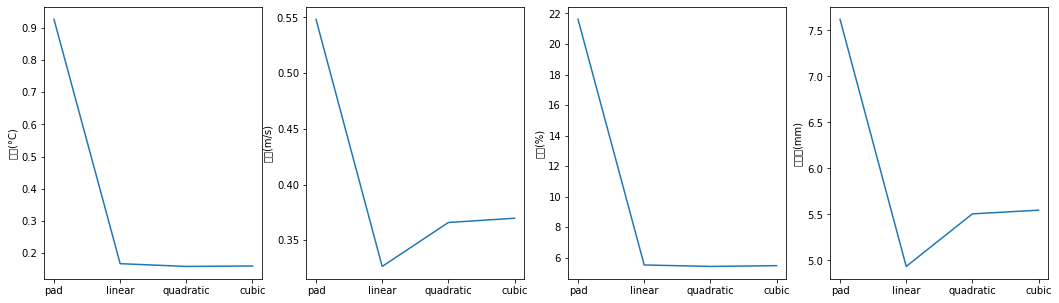

In [21]:
# 클러스터링 관련함수
from sklearn.metrics import mean_squared_error, mean_absolute_error # 성능 측정지표 mae, mae

all_cols_error_dict = dict()  # 총 딕셔너리
for col in ['기온(°C)', '풍속(m/s)', '습도(%)', '강수량(mm)']: # 기온, 풍속, 습도, 강수량 을 순차적으로 가져옴 
    methods = ['pad','linear','quadratic','cubic']
    error_dict = compare_interpolate_methods(col, methods, mean_squared_error)  # 보간법 비교 함수 실행
    all_cols_error_dict['{}'.format(col)] = error_dict  # 해당 컬럼에 적용된 보간법 메소드들을 총 딕셔너리에 추가  --> 컬럼값이 키값이됨
    
all_cols_error_df = pd.DataFrame(all_cols_error_dict)  # 데이터프레임으로 변환

# 그래프 출력
fig, axes = plt.subplots(1,4, figsize = (18,5), sharey=False)  
# 서브 플롯 그리드의 행 / 열 수 , 그래프 사이즈, sharex, shareybool or {'none', 'all', 'row', 'col'}, default: False --> True 또는 'all': x 축 또는 y 축이 모든 서브 플롯간에 공유
# False 또는 'none': 각 서브 플롯 x 축 또는 y 축이 독립
# 'row': 각 서브 플롯 행은 x 축 또는 y 축을 공유
# 'col': 각 서브 플롯 열은 x 축 또는 y 축을 공유

for i in range(len(all_cols_error_df.columns)): # 컬럼 갯수만큼 순차적으로 그래프를 그림
    sns.lineplot(ax=axes[i], data=all_cols_error_df.iloc[:,i].transpose()) # .transpose() : 행과 열을 바꿈 --> 컬럼별로 그래프를 그림 x축 --> 메소드이름 , y축 정보 손실 정도?

In [22]:
#기온 결측치 채우기
test['기온(°C)'] = test['기온(°C)'].interpolate(method='quadratic')
#마지막 na 채우기
test['기온(°C)'] = test['기온(°C)'].interpolate(method='linear')

#풍속 결측치 채우기
test['풍속(m/s)'] = test['풍속(m/s)'].interpolate(method='linear')

#습도 결측치 채우기
test['습도(%)'] = test['습도(%)'].interpolate(method='quadratic')
#마지막 na 채우기
test['습도(%)'] = test['습도(%)'].interpolate(method='linear')

#강수량 결측치 채우기
test['강수량(mm, 6시간)'] = test['강수량(mm, 6시간)'].interpolate(method='linear')

In [23]:
print('\033[1m<test함수 변수별 결측값 수> \033[0m\n', test.isna().sum())

<test함수 변수별 결측값 수> 
 num             0
date_time       0
기온(°C)          0
풍속(m/s)         0
습도(%)           0
강수량(mm, 6시간)    0
일조(hr, 3시간)     0
month           0
day             0
hour            0
weekday         0
weekend         0
비전기냉방설비운영       0
태양광보유           0
dtype: int64


### 새로운 변수 : 불쾌지수 생성
날씨 변수를 이용하여 쾌적함의 척도로써 여름철 에어컨 사용 등 전력사용량에 영향을 미칠 것으로 예상되는 불쾌지수를 추가
불쾌지수=1.8x기온–0.55x(1–습도)x(1.8x기온–26)+32

In [24]:
train['불쾌지수'] = 1.8*train['기온(°C)'] - 0.55*(1-(train['습도(%)']/100))*(1.8*train['기온(°C)']-26) + 32
test['불쾌지수'] = 1.8*test['기온(°C)'] - 0.55*(1-(test['습도(%)']/100))*(1.8*test['기온(°C)']-26) + 32

In [25]:
# (데이터프레임 변수 순서 정리)
train = train[['num','date_time','month', 'day', 'hour','weekday','weekend','기온(°C)','습도(%)','불쾌지수','풍속(m/s)','강수량(mm)','일조(hr)','비전기냉방설비운영','태양광보유','전력사용량(kWh)']]
test = test[['num','date_time','month', 'day', 'hour','weekday','weekend','기온(°C)','습도(%)','불쾌지수','풍속(m/s)','강수량(mm, 6시간)','일조(hr, 3시간)','비전기냉방설비운영','태양광보유']]

## Data Analysis

### 전력사용량 EDA

#### 건물들의 평균 전력 사용량 시각화

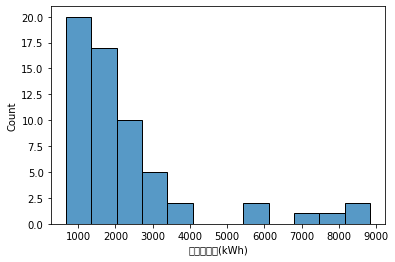

In [26]:
sns.histplot(train.groupby('num')['전력사용량(kWh)'].mean())

한 시간에 평균 1000kWh를 쓰는 건물부터 9000kWh를 쓰는 건물까지 건물마다 전력사용량의 총량이 매우 다양하다는 것을 확인

#### 건물 변수와 전력사용량의 관계

In [27]:
train.groupby(['비전기냉방설비운영','태양광보유'])['전력사용량(kWh)'].mean()

비전기냉방설비운영  태양광보유
0.0        0.0      2077.030506
           1.0      1582.298192
1.0        0.0      2101.993590
           1.0      2949.726621
Name: 전력사용량(kWh), dtype: float64

- 일반적으로 비전기냉방설비를 운영하고 태양광을 보유하면 전력사용량이 더 적을 것으로 예상
- 건물별 거주인구, 유동인구 및 건물면적 등의 정보를 모르기 때문에 주어진 건물 변수와 전력사용량의 관계를 정확히 알 수는 없지만, 예상과 달리 비전기냉방설비운영 여부, 태양광보유 여부가 건물의 전력사용량을 낮춰주진 않는다는 것을 확인

#### 다른 변수들과 전력 사용량의 관계

In [28]:
train['num'].describe() # 건물번호의 시작과 끝을 확인

count    122400.000000
mean         30.500000
std          17.318173
min           1.000000
25%          15.750000
50%          30.500000
75%          45.250000
max          60.000000
Name: num, dtype: float64

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


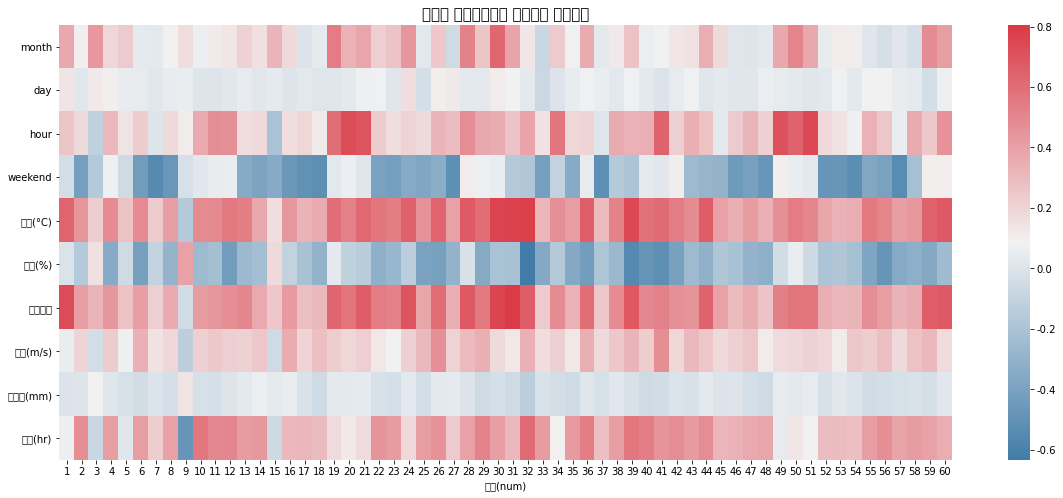

In [29]:
corr = []  # 상관관계
for num in range(1,61): # 건물번호가 1부터 60까지 있으므로 순차적으로 확인
    df = train[train.num==num]  # train의 건물번호와 해당 번호가 같은 데이터프레임을 생성
    num_corr = df.corr()['전력사용량(kWh)']  # 해당 건물번호와 전력사용량의 상관관계 확인
    num_corr = num_corr.drop(['num','비전기냉방설비운영','태양광보유','전력사용량(kWh)']) # 다른 필요없는 변수 드랍
    corr.append(num_corr) # 총 상관관계 리스트에 해당 건물번호와 전력량에 대한 상관관계를 추가
corr_df = pd.concat(corr, axis=1).T # concat : 속성 형태가 동일한 데이터셋을 합침, T : 인덱스와 열을 바꿈
corr_df.index = list(range(1,61)) # 인덱스를 건물번호로 초기화

# 시각화
f, ax = plt.subplots(figsize=(20,8))
plt.title("건물별 전력사용량과 변수들의 상관관계", fontsize=15)
sns.heatmap(corr_df.T, cmap=sns.diverging_palette(240,10,as_cmap=True), ax=ax)
plt.xlabel('건물(num)')
plt.show()

**건물별로 전력사용량과의 각 변수들의 상관계수가 다름**
- 건물1: 기온과 강한 양의 상관관계를 가지고,
- 건물9: 기온과는 상관관계가 거의 없고, 일조와 음의 상관관계를 가집니다.

이후 전력사용량을 모델링할 때 이를 기반으로 건물별로 다른 변수를 사용

### 시계열 분석
- 건물별로 시계열 분포가 다르므로 대표로 2개의 건물(건물4, 건물9)에 대해 시계열 분석을 하여 어떤 시계열적 특징이 있는지 확인

#### 시계열 분해
- 우선 시계열 분해를 통해 건물별 전력사용량을 추세, 계절성, 잔차로 분해

In [30]:
#Time Series Analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [31]:
def vis_time_series_decompose(num):
    df = train[train.num==num]
    df.index = df.date_time

    res = sm.tsa.seasonal_decompose(df['전력사용량(kWh)'], model='additive')

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
    res.observed.plot(ax=ax1, title='Observed')
    res.trend.plot(ax=ax2, title='Trend')
    res.resid.plot(ax=ax3, title='Residual')
    res.seasonal.plot(ax=ax4, title='Seasonal')
    plt.tight_layout()
    plt.show()

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


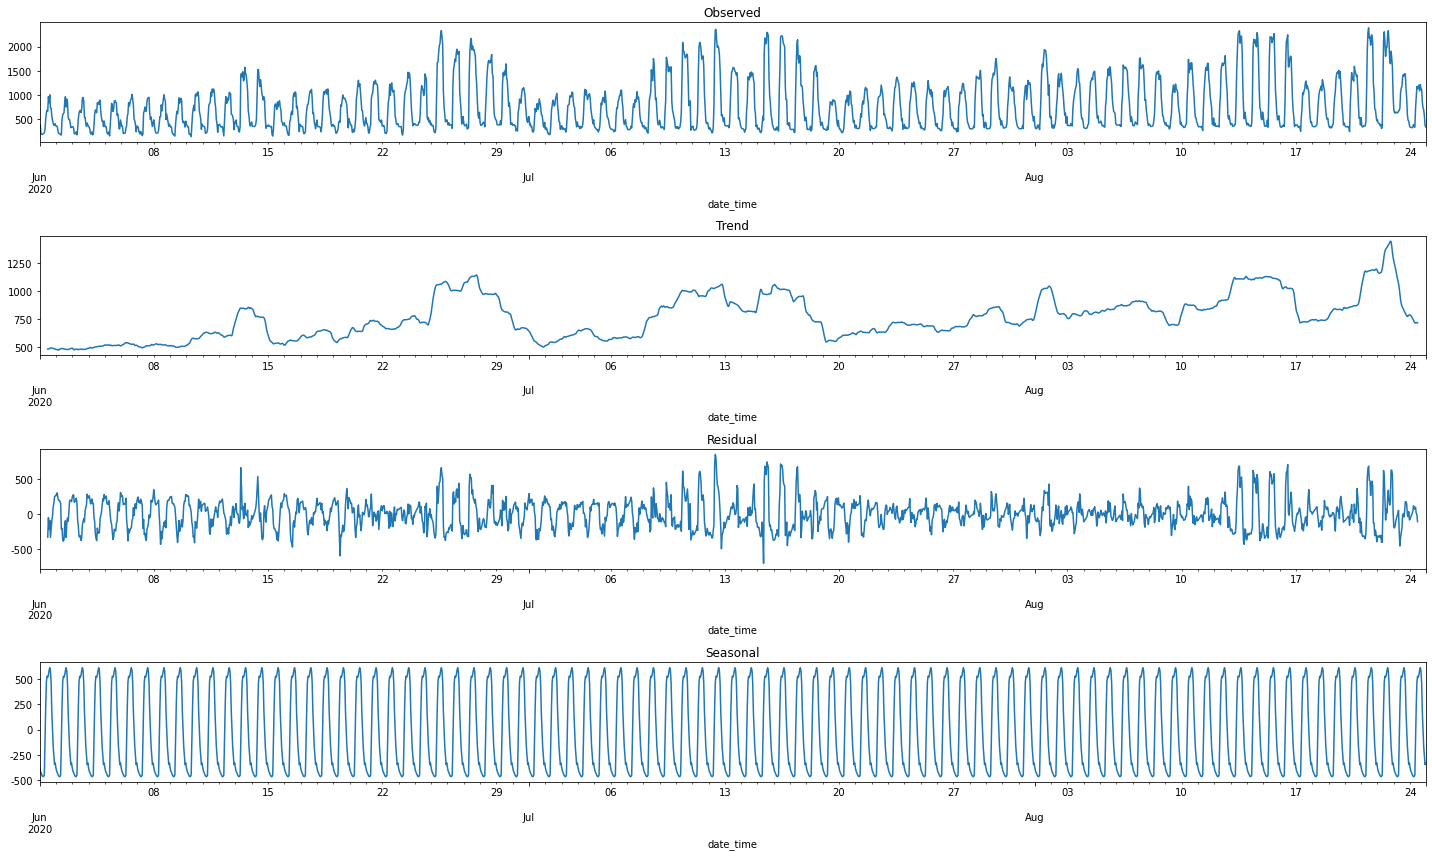

In [32]:
## 건물4
vis_time_series_decompose(num=4)

- 건물4의 경우, 하루를 주기로 계절성을 지님
- 85일동안 특별히 증가하거나 감소하는 추세는 보이지 않음

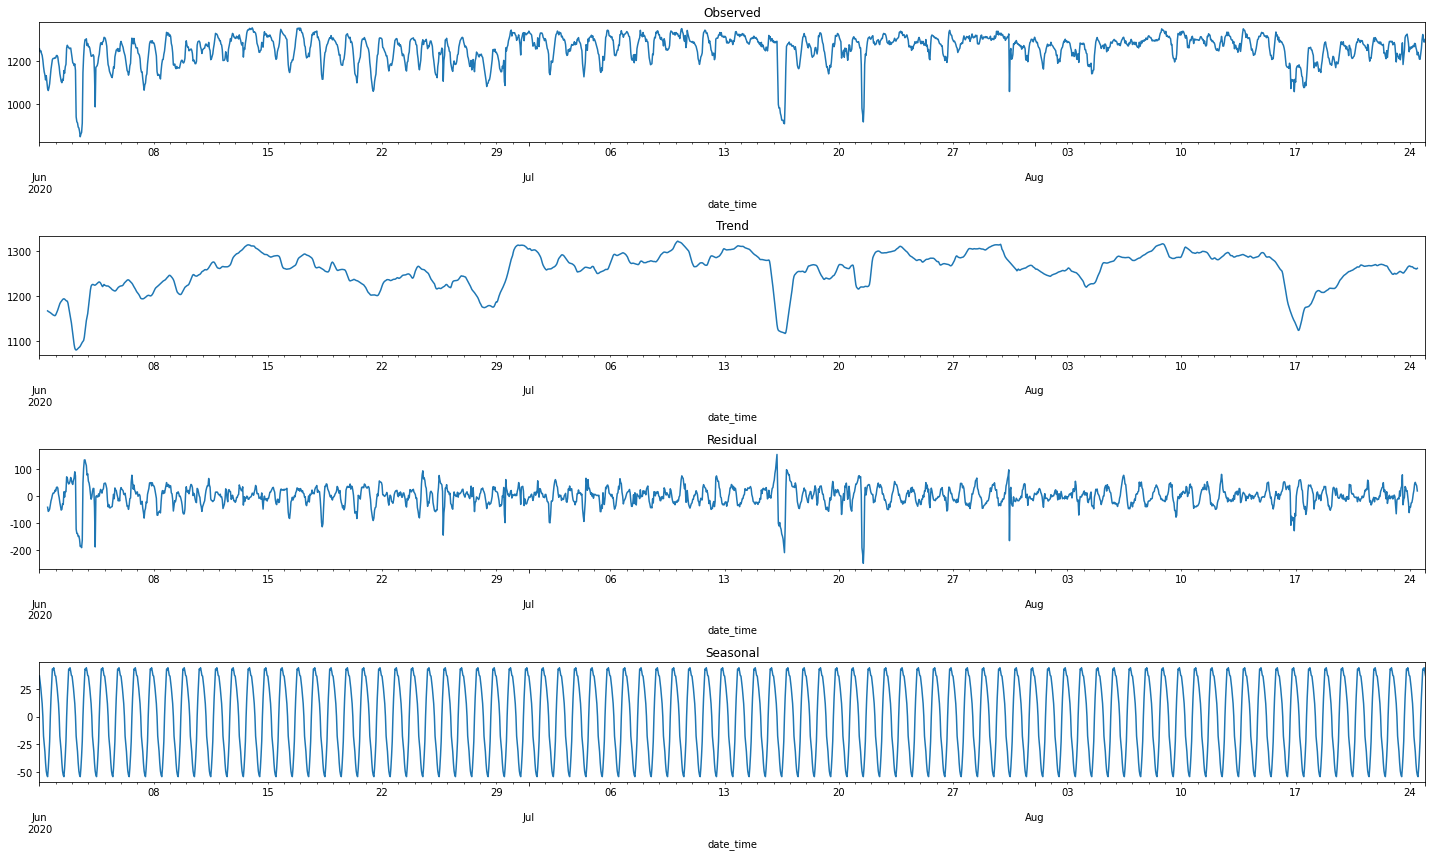

In [33]:
## 건물9
vis_time_series_decompose(num=9)

- 두 건물 모두 하루 단위의 계절성이 존재함으로 하루 단위로 시간에 따른 전력사용량을 관찰할 필요가 있음
- 건물별로 시간별 평균 전력사용량에 대한 분석을 진행

#### 자기상관, 부분자기상관

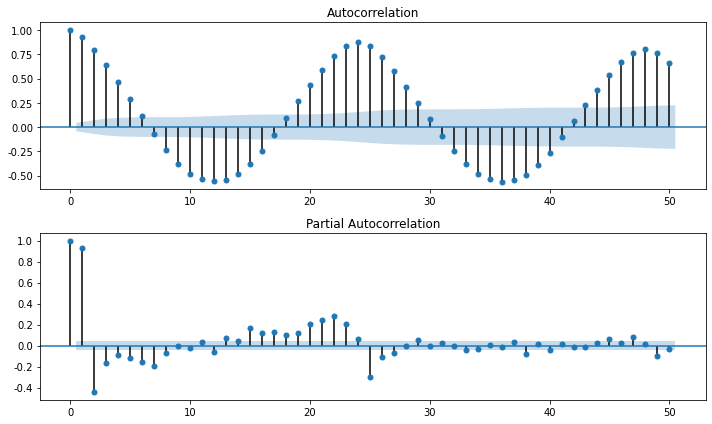

In [34]:
## 건물4
df = train[train.num==4]
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df['전력사용량(kWh)'], lags=50, ax=ax1)
plot_pacf(df['전력사용량(kWh)'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

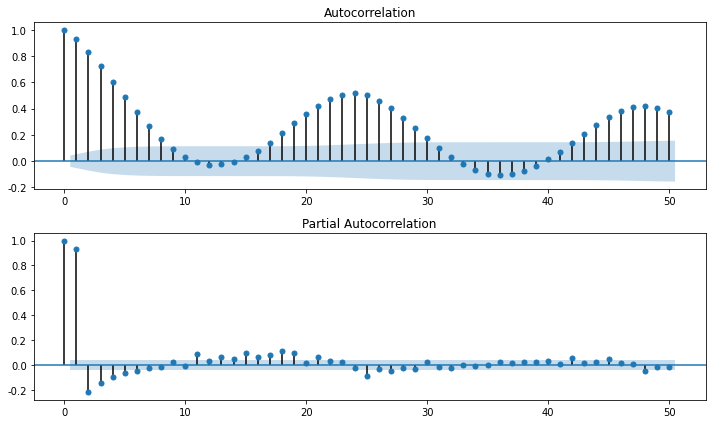

In [35]:
## 건물9
df = train[train.num==9]
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df['전력사용량(kWh)'], lags=50, ax=ax1)
plot_pacf(df['전력사용량(kWh)'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

- PACF를 봤을 때 두 건물 모두 전력사용량은 1시간, 2시간 전과 크게 관계가 있고, 약 24시간 전의 전력사용량에도 약간의 영향을 받음을 확인
- 시계열 예측을 진행할 때 직전 시간뿐만 아니라, 24시간 전의 데이터도 활용하여 학습 필요

### 각 건물의 시간에 따른 평균 전력사용량 확인

#### 시간별 평균 전력사용량

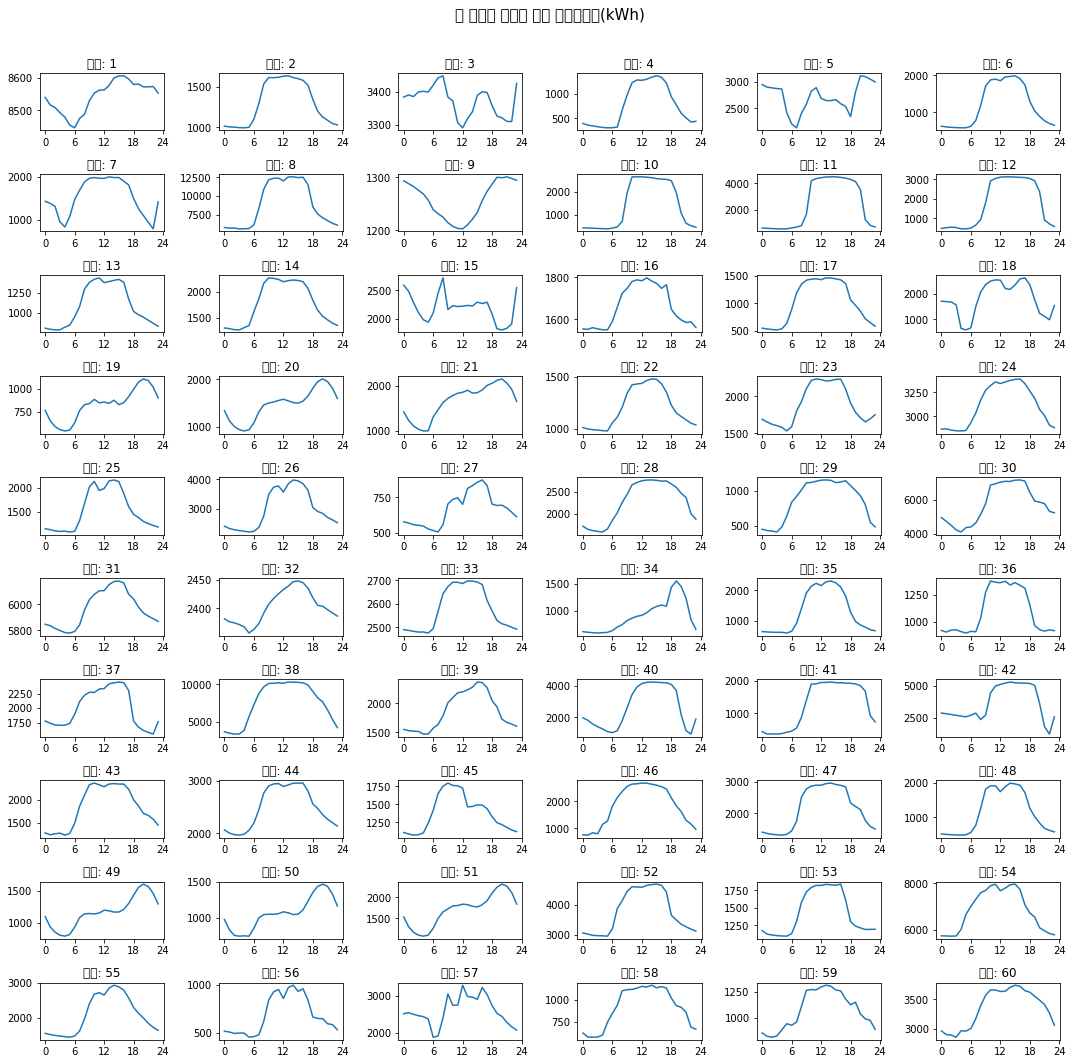

In [36]:
fig = plt.figure(figsize = (15 ,15))
plt.title("각 건물의 시간별 평균 전력사용량(kWh)", fontsize=15, y=1.05)
plt.axis('off')

for num in range(1,61):
    df = train[train.num==num]
    ax = fig.add_subplot(10,6,num) # 10행 6열 빈 그래프 생성
    ax.plot(df['hour'].unique(), df.groupby('hour')['전력사용량(kWh)'].mean())
    ax.set_title(f'건물: {num}')
    ax.set_xticks([0,6,12,18,24]) # 시간
plt.tight_layout()
plt.show()

- 건물들은 하루동안 시간별로 각각 다르지만 또 비슷한 전력 사용 패턴을 보임
- 눈에 띄는 패턴에 따라 건물들을 나눠 분석해보았습니다.

    - 6시에 전력사용량이 증가하여 9시~18시까지 전력사용량이 많은 건물
        - 예시: 2, 4, 6, 8 등
        - 용도 추측: 상가, 사무실이 많은 회사 건물
    - 1번 패턴과 비슷하나 12시쯤에 전력이 약간 줄어드는 건물
        - 예시: 6, 8, 13, 14 등
        - 용도 추측: 점심시간을 갖는 회사가 모인 건물
    - 1번 패턴과 비슷하나 자정쯤에 전력량이 상승하는 건물
        - 예시: 7, 18, 23, 42 등
        - 용도 추측:새벽에 서버를 돌리는 회사가 있는 건물
    - 6시부터 상승하여 16시까지 비슷하다가 이후 20시쯤 피크를 찍는 건물
        - 예시: 19, 20, 21, 49 등
        - 용도 추측: 학원이 많은 건물, 24시간 카페가 있는 건물
    - 저녁~새벽에 전력사용량이 많은 건물
        - 예시: 9 등
        - 용도 추측: 저녁에 영업하는 주점 등이 있는 상가 건물일 가능성 높음
- 이외에도 건물3의 경우 8시, 16시쯤 피크를 찍는 형태를 보이는 등의 패턴을 보임

#### 요일별 평균 전력사용량

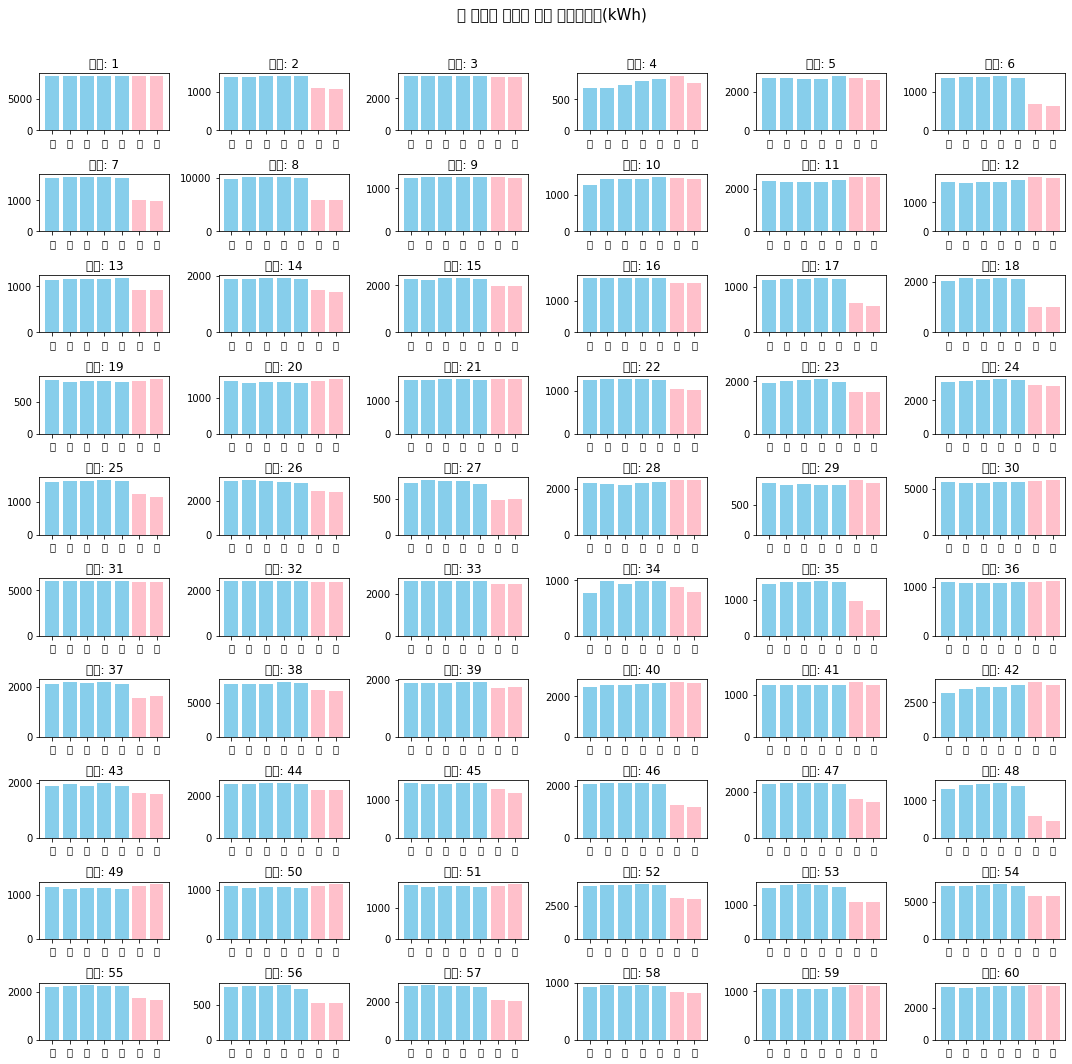

In [37]:
fig = plt.figure(figsize = (15 ,15))
plt.title("각 건물의 요일별 평균 전력사용량(kWh)", fontsize=15, y=1.05)
plt.axis('off')

weekday = ['월','화','수','목','금','토','일']
colors = ['skyblue','skyblue','skyblue','skyblue','skyblue','pink','pink']

for num in range(1,61):
    df = train[train.num==num]
    df_counts = df.groupby('weekday')['전력사용량(kWh)'].mean()
    df_counts = df_counts.reindex(weekday)
    ax = fig.add_subplot(10,6,num)
    ax.bar(df['weekday'].unique(), df_counts, color=colors)
    ax.set_title(f'건물: {num}')
plt.tight_layout()
plt.show()

- 일주일동안의 전력사용량을 요일별로 보면 크게 3가지 패턴으로 나뉨

1. 주말에 사용량이 감소하는 건물
    - 예시: 2, 6, 7 등 다수
    - 용도 추측: 사무실이 많은 회사 건물, 학교
2. 주말에 사용량이 약간 증가하는 건물
    - 예시: 11, 12 등
    - 용도 추측: 주거용 건물
3. 요일 상관없이 사용량이 일정한 건물
    - 예시: 1, 9
    - 용도 추측: 대학병원

#### 시간+요일별 평균 전력사용량

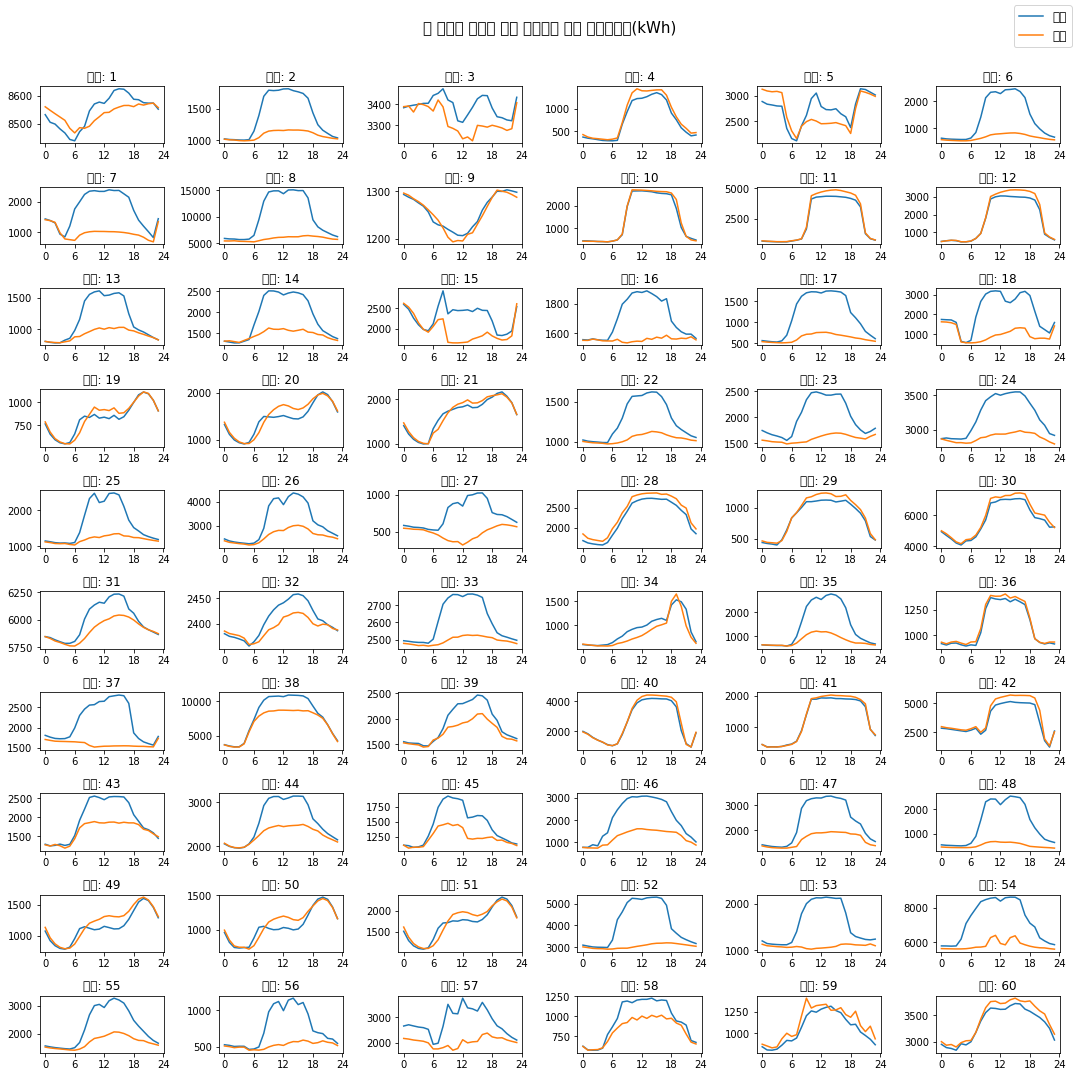

In [38]:
fig = plt.figure(figsize = (15 ,15))
plt.title("각 건물의 시간에 따른 주말여부 평균 전력사용량(kWh)", fontsize=15, y=1.05)
plt.axis('off')

for num in range(1,61):
    df = train[train.num==num]
    ax = fig.add_subplot(10,6,num)
    ax.plot(df['hour'].unique(), df[df.weekend==0].groupby('hour')['전력사용량(kWh)'].mean(), label='평일')
    ax.plot(df['hour'].unique(), df[df.weekend==1].groupby('hour')['전력사용량(kWh)'].mean(), label='주말')
    ax.set_title(f'건물: {num}')
    ax.set_xticks([0,6,12,18,24])
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc = 1, prop={'size':12})
plt.tight_layout()
plt.show()

- 평일과 주말을 나눠 하루동안의 전력사용량을 시각화

1. 평일과 주말의 패턴이 비슷한 건물
    - 예시: 4, 9, 10 등
2. 평일과 주말의 낮시간대의 사용량이 차이나는 건물
    - 예시: 2, 6, 7 등
3. 평일과 주말의 패턴이 반대인 건물
    - 예시: 27

- 건물마다 시간에 따른 패턴이 다르지만 일정한 기준에 의해 묶을 수 있을 것으로 보임
- 군집화를 통해 비슷한 패턴을 가진 건물끼리 묶음

## 군집화

- KMeans와 SOM의 두 가지 알고리즘을 사용하여 건물을 군집화

In [45]:
!pip install tslearn
!pip install minisom

  Created wheel for minisom: filename=MiniSom-2.2.9-cp37-none-any.whl size=8595 sha256=3217eb69de73f47a1f1b09bfbf8d555c608b98bbcf781f8ae93e6f5a3f7ef041
  Stored in directory: /root/.cache/pip/wheels/de/a0/08/5234d6b02b29c561f62b6c985e2eb7d480fb0b92359a8c74e4
Successfully built minisom


In [46]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler # 정규화 관련 함수
from tslearn.clustering import TimeSeriesKMeans, silhouette_score # 클러스터링 함수
from minisom import MiniSom

In [47]:
## 시계열 군집화용 DataFrame을 생성하는 함수 (row->num, col->date_time)
def cluster_df(scaler=MinMaxScaler()): # scaler=[False, 'MinMaxScaler()', 'StandardScaler()']
    train_ = train.copy()
    train_ts = train_.pivot_table(values='전력사용량(kWh)', index=train_.num, columns='date_time', aggfunc='first')
    
    if scaler:
        train_ts_T = scaler.fit_transform(train_ts.T)
        train_ts = pd.DataFrame(train_ts_T.T, index=train_ts.index, columns=train_ts.columns)
    
    return train_ts

In [48]:
## SOM 알고리즘 결과를 정리해주는 DataFrame을 생성하는 함수
def make_som_df(X):
    win_map = som.win_map(X)
    som_result = []
    for i in range(60):
        som_result.append([i+1, som.winner(X[i])])
    som_df = pd.DataFrame(som_result, columns=['num','cluster'])
    return som_df

In [49]:
## 여러 n_clueter에 대해 TimeSeriesKmeans를 시행하고 이를 시각화하는 함수
def visualize_n_cluster(train_ts, n_lists=[3,4,5,6], metric='dtw', seed=2021, vis=True):

    if vis:
        fig = plt.figure(figsize = (20 ,5))
        plt.title("군집 개수별 건물수 분포", fontsize=15, y=1.2)
        plt.axis('off')
    
    for idx, n in enumerate(n_lists):
        ts_kmeans = TimeSeriesKMeans(n_clusters=n, metric=metric, random_state=seed)
        train_ts['cluster(n={})'.format(n)] = ts_kmeans.fit_predict(train_ts)
        score = round(silhouette_score(train_ts, train_ts['cluster(n={})'.format(n)], metric='euclidean'),3)
        
        vc = train_ts['cluster(n={})'.format(n)].value_counts()
        
        if vis:
            ax = fig.add_subplot(1,len(n_lists), idx+1)
            sns.barplot(x=vc.index, y=vc, palette='Pastel1')
            ax.set(title='n_cluster={0}\nscore: {1}'.format(n,score))
    if vis: 
        plt.tight_layout()
        plt.show()
    
    return train_ts

In [50]:
## 클러스터 별 시간&요일별 전력사용량 평균 시각화 (new)
def visualize_by_cluster(df_with_labels, n_cluster, algorithm):
    fig = plt.figure(figsize = (20 ,4*n_cluster))
    plt.title('군집 수가 {}개일 때 각 군집별 시계열분포'.format(n_cluster), fontsize=15, y=1.05)
    plt.axis('off')
    
    if algorithm=='kmeans': # kmeans 를 통해서 클러스터링
        labels = df_with_labels['cluster(n={})'.format(n_cluster)]
    elif algorithm=='som': # som 을 통해서 클러스터링
        labels = df_with_labels.cluster
    
    idx=1
    for label in set(labels): # 각 군집에 대해
        
        if algorithm=='kmeans':
            df = train[train.num.isin(list(labels[labels==label].keys()))]
        elif algorithm=='som':
            df = train[train.num.isin(som_df[som_df.cluster==label].num.values)]
        
        hour = df.hour.unique()
        weekday = df.weekday.unique()
        
        ### x축: 시간 ###
        ax = fig.add_subplot(n_cluster,2, idx); idx+=1
        ax.set(title='{}번 군집의 시간별 평균 전력사용량'.format(label))
        ax.set_xticks(hour)
        for num in df.num.unique():
            df_one = df[df.num==num]
            sns.lineplot(x=hour, y=df_one.groupby('hour')['전력사용량(kWh)'].mean(), color='grey', alpha=0.3)
        sns.lineplot(x=hour, y=df.groupby('hour')['전력사용량(kWh)'].mean(), color='red')
        
        ### x축: 요일 ###
        ax = fig.add_subplot(n_cluster,2, idx); idx+=1
        ax.set(title='{}번 군집의 요일별 평균 전력사용량'.format(label))
        for num in df.num.unique():
            df_one = df[df.num==num]
            df_one_counts = df_one.groupby('weekday')['전력사용량(kWh)'].mean()
            df_one_counts = df_one_counts.reindex(weekday)
            sns.lineplot(x=weekday, y=df_one_counts, color='grey', alpha=0.3)
        df_counts = df.groupby('weekday')['전력사용량(kWh)'].mean()
        df_counts = df_counts.reindex(weekday)
        sns.pointplot(x=weekday, y=df_counts, color='red')
        ax.legend(['총 {}개 건물'.format(df.num.nunique())], loc=1)

    plt.show()

### k-maens 클러스터링

- 전력사용량을 StandardScaler를 이용하여 표준화하여 건물별 전력의 절대적 사용량이 아닌 사용 패턴을 사용하여 군집화

- 각 관측치간의 거리를 계산할 때는 euclidean 거리를 사용
    - 시계열 데이터에서는 시간대가 다르더라도 계산할 수 있다는 장점을 지닌 DTW(Dynamic Time Warping) 거리 계산 방법도 많이 사용하지만, 본 데이터는 건물별로 측정 기간이 때문에 속도가 빠른 euclidean 거리 계산 방법을 사용

- 군집수의 범위는 위에서 건물별 평균 전력사용량을 시각화하였을 때 크게 3~6개의 패턴을 확인하였으므로 군집수를 3,4,5,6개로 설정하여 실루엣계수와 각 군집별 분포를 시각화

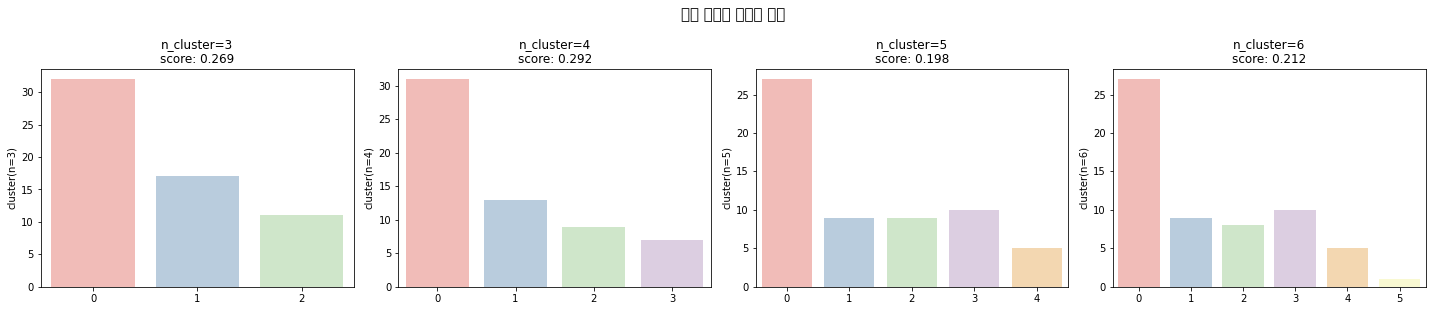

In [51]:
train_ts = cluster_df(scaler=StandardScaler())
train_ts = visualize_n_cluster(train_ts, n_lists=[3,4,5,6], metric='euclidean', seed=2021, vis=True)

- 실루엣 계수가 높고 각 군집별로 건물 수가 극단적으로 치우치지 않은 n_cluster=4일 때를 선택하여 군집화를 진행

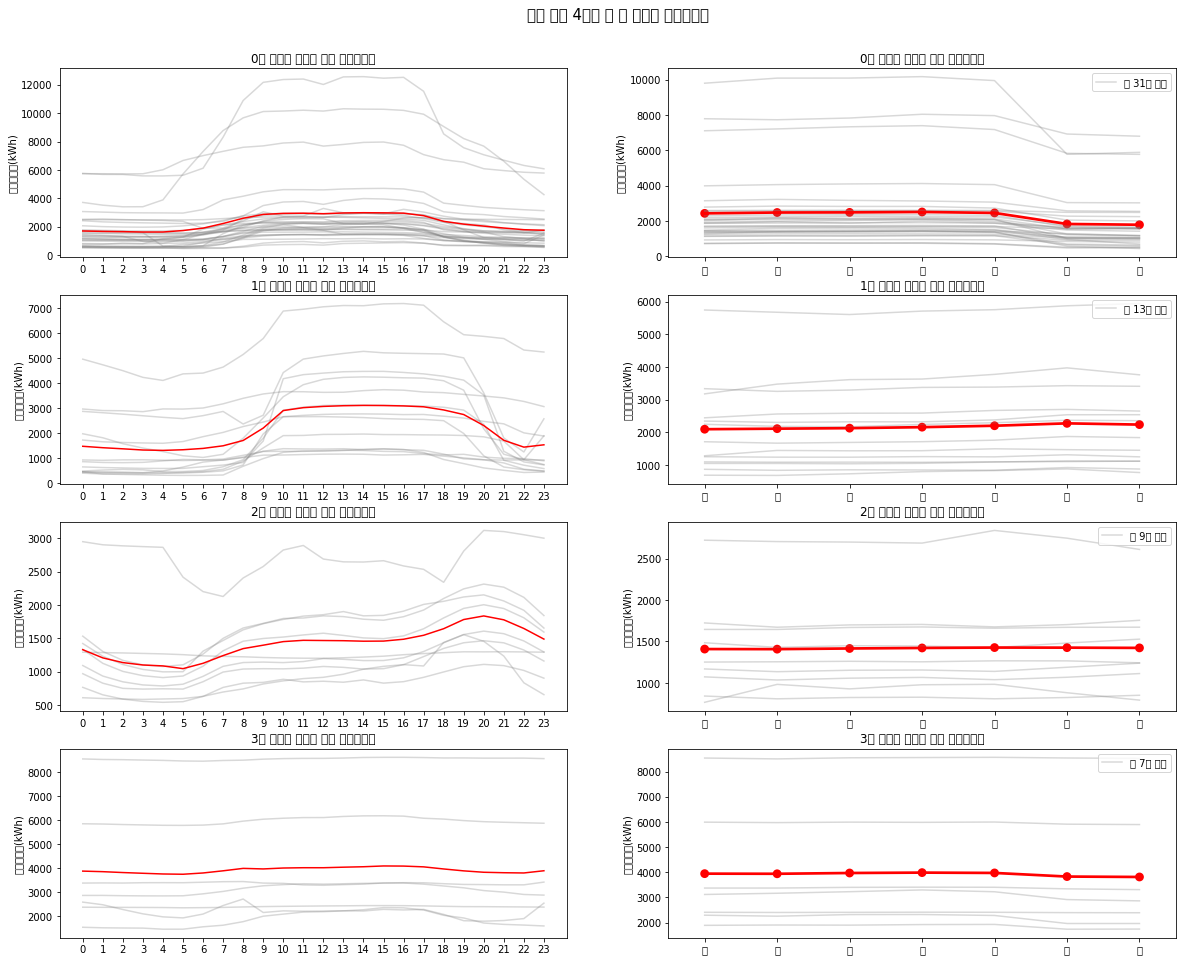

In [52]:
visualize_by_cluster(train_ts, n_cluster=4, algorithm='kmeans')

**각 군집별 내에서 건물들이 비슷한 패턴을 보임**

- 0번 군집: 6시~18시까지 전력사용량이 많고, 주말보다 평일의 전력사용량이 많은 건물들
- 1번 군집: 8시~20시까지 전력사용량이 많고, 주말과 평일의 전력사용량이 비슷한 건물들
- 2번 군집: 저녁 시간대에 전력사용량이 많고, 주말과 평일의 전력사용량이 비슷한 건물들
- 3번 군집: 시간별 전력사용량의 차이가 크지 않고, 주말과 평일의 전력사용량이 비슷한 건물들

### SOM(Self-Organizing Maps)

- 두 번째로 간단한 Neural Net인 SOM 알고리즘을 이용하여 전력사용량에 따라 건물을 군집화

- 마찬가지로 건물별로 전력사용량 표준화를 진행하였고, 2x3의 그리드를 만들어 군집화

In [53]:
train_ts = cluster_df(scaler=StandardScaler())
X = train_ts.values

som = MiniSom(x=2, y=3, input_len = X.shape[1])
som.random_weights_init(X)
som.train(data=X, num_iteration=50000)

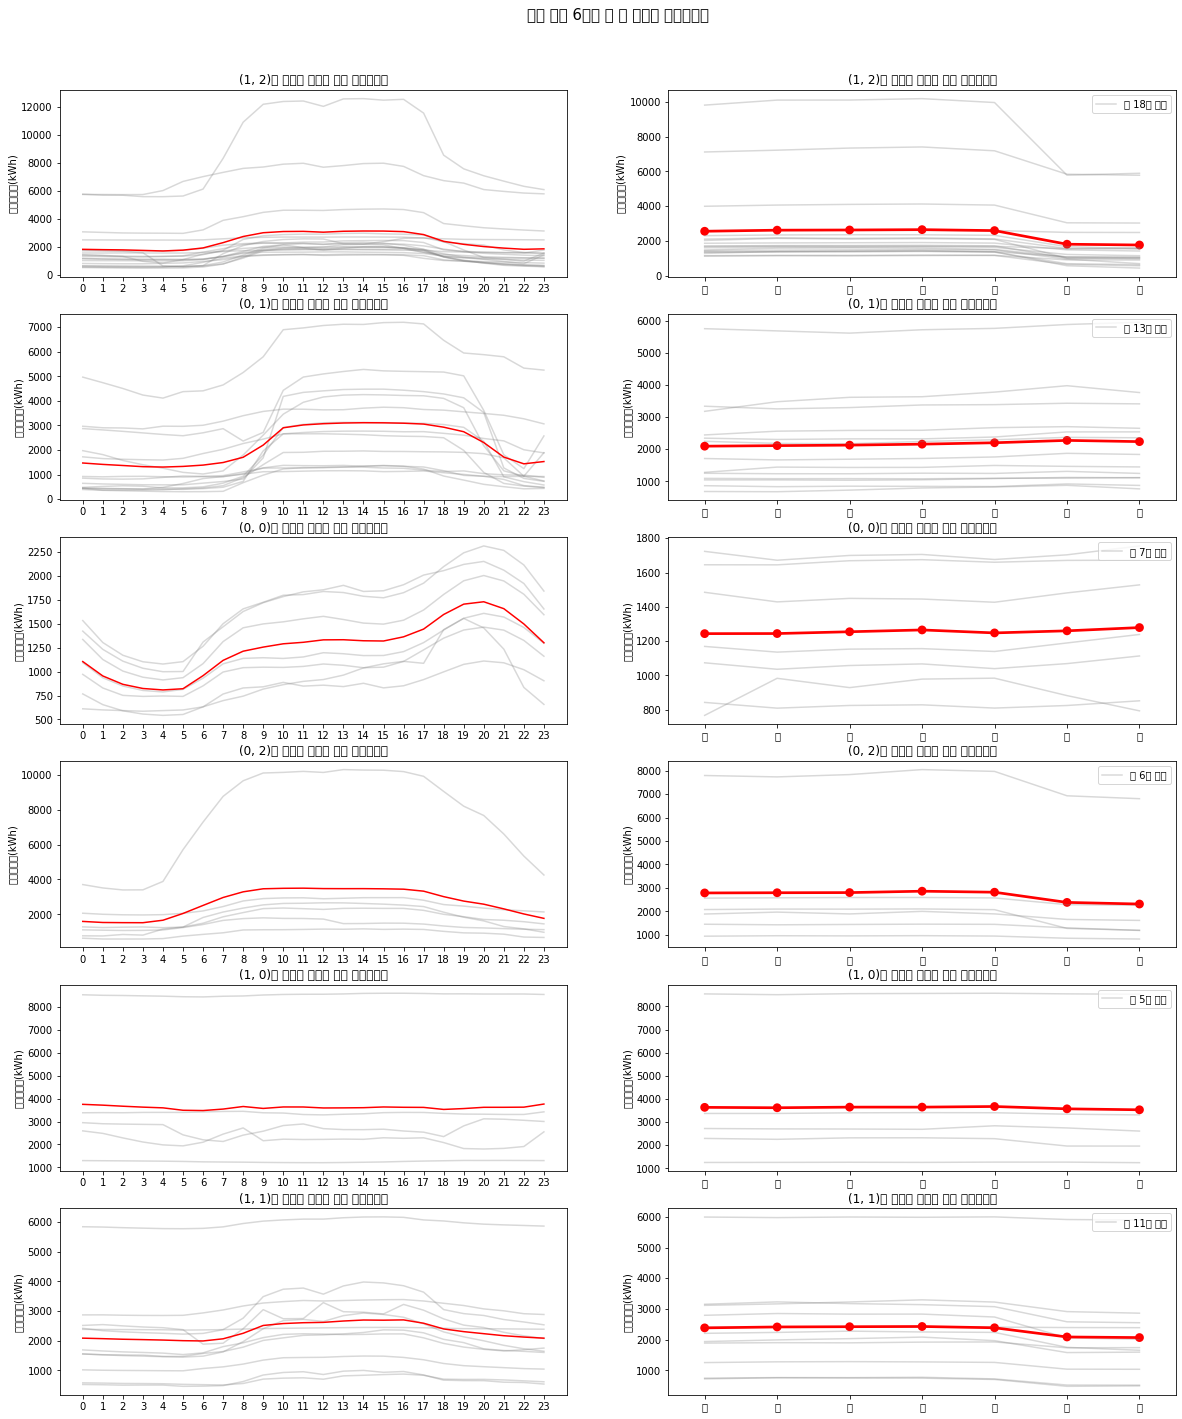

In [54]:
som_df = make_som_df(X)
visualize_by_cluster(som_df, 6, algorithm='som')

**마찬가지로 각 군집별 내에서 건물들이 비슷한 패턴을 보임**

- (1,2)번 군집: 6시~18시까지 전력사용량이 많고, 주말보다 평일의 전력사용량이 많은 건물들
- (0,1)번 군집: 8시~20시까지 전력사용량이 많고, 주말과 평일의 전력사용량이 비슷한 건물들
- (0,0)번 군집: 저녁 시간대에 전력사용량이 많은 건물들
- (0,2)번 군집: 이른 아침부터 저녁까지 전력사용량이 많고, 주말보다 평일의 전력사용량이 많은 건물들
- (1,0)번 군집: 시간별 전력사용량의 차이가 크지 않고, 주말과 평일의 전력사용량이 비슷한 건물들
- (1,1)번 군집: 8시~20시까지 전력사용량이 많고, 주말보다 평일의 전력사용량이 많은 건물들

## 모델링

### LSTM
- 각 건물별로 전력사용량과의 상관관계가 0.3 이상인 변수를 이용하여 Multivariate Time Series 데이터를 LSTM에 적합하여 학습 및 예측을 진행

In [55]:
# 건물별 모델 및 예측 결과 저장
model_history = {}
forecast_future = {}
predict_past = {}

In [59]:
#Modeling
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout

In [61]:
# Custom Loss Function
# 모델 평가 지표 
# https://pseudo-lab.github.io/Tutorial-Book/chapters/time-series/Ch1-Time-Series.html#smape-symmetric-mean-absolute-percentage-error
import keras.backend as K

def SMAPE(true,predicted):
    epsilon = 0.1
    summ = K.maximum(K.abs(true) + K.abs(predicted) + epsilon, 0.5 + epsilon)
    smape = K.abs(predicted - true) / summ * 2.0
    return smape

In [62]:
for num in tqdm(range(1,61)):  # tqdm = 진행률 시각화
    
    ## 피처 골라내서 데이터프레임 만들기
    train_num1 = train_[train_.num==num]
    train_num1_corr = train_num1.corr()['전력사용량(kWh)']
    variables = train_num1_corr[abs(train_num1_corr)>0.3].keys().tolist()
    train_num1 = train_num1[variables]
    
    ## 정규화
    if train_num1.shape[1]>1:
        feature_scaler = MinMaxScaler()
        train_num1.iloc[:,:-1] = feature_scaler.fit_transform(train_num1.iloc[:,:-1])

    y_scaler = StandardScaler()
    y_scaler.fit(train_num1[['전력사용량(kWh)']])
    train_num1['전력사용량(kWh)'] = y_scaler.transform(train_num1[['전력사용량(kWh)']])

    train_num1 = train_num1.values
    
    ## 시계열 데이터 만들기
    train_X = []
    train_y = []

    n_future = 1
    n_past = 24 ## 24시간 전의 데이터까지 고려

    for i in range(n_past, len(train_num1)-n_future+1):
        train_X.append(train_num1[i-n_past:i, 0:train_num1.shape[1]])
        train_y.append(train_num1[i+n_future-1:i+n_future, -1])
    train_X, train_y = np.array(train_X), np.array(train_y)
    
    ## 모델 형성
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(train_y.shape[1]))
    model.compile(optimizer='adam', loss=SMAPE)

    ## 모델 학습
    history = model.fit(train_X, train_y, epochs=10, batch_size=16, validation_split=0.1, verbose=0, shuffle=False)
    model_history['num{}'.format(num)] = history
    
    ## 예측
    ### 1. 테스트데이터 예측
    n_future = 168
    forecast_period_dates = test[test.num==num]['date_time'].tolist()
    forecast = model.predict(train_X[-n_future:])
    y_pred_future = y_scaler.inverse_transform(forecast)[:,0]
    forecast_future['num{}'.format(num)] = y_pred_future
    
    ### 2. 학습데이터 예측
    predict_train = model.predict(train_X)
    predict_train = y_scaler.inverse_transform(predict_train)
    predict_train = predict_train[:,0]
    predict_past['num{}'.format(num)] = predict_train

**건물1에 대한 예측을 시각화**

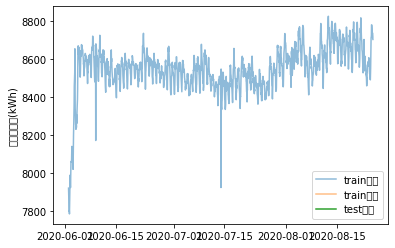

In [63]:
train_dates = train.date_time.unique()[24:]
test_dates = test.date_time.unique()
y_pred_future = forecast_future['num1']
predict_train = predict_past['num1']

sns.lineplot(x=train_dates, y=train[train.num==1]['전력사용량(kWh)'][24:], alpha=0.5, label='train기존')
sns.lineplot(x=train_dates, y=predict_train, alpha=0.5, label='train예측')
sns.lineplot(x=test_dates, y=y_pred_future, label='test예측')

train 범위에서 기존의 데이터와 예측값이 대체로 겹치는 것으로 보아 학습이 제대로 된 것을 알 수 있고, test 범위에서도 train 데이터와 매끄럽게 이어지는 것을 확인

In [64]:
submission['answer'] = pd.DataFrame(forecast_future).T.values.reshape(-1) # 결과저장

In [66]:
submission.head(10)

,num_date_time,answer
0,1 2020-08-25 00,NaN
1,1 2020-08-25 01,NaN
2,1 2020-08-25 02,NaN
3,1 2020-08-25 03,NaN
4,1 2020-08-25 04,NaN
5,1 2020-08-25 05,NaN
6,1 2020-08-25 06,NaN
7,1 2020-08-25 07,NaN
8,1 2020-08-25 08,NaN
9,1 2020-08-25 09,NaN


In [65]:
submission.to_csv('submission.csv')